<a href="https://colab.research.google.com/github/lariannrupp/Machine_Learning_Algorithmic_Trading_Bot/blob/main/TechSector_Trade_Bot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Technology Sector 

In [3]:
# Import the required libraries and dependencies

!pip install alpaca_trade_api 
!pip install hvplot
!pip install yfinance

import os
import requests
import pandas as pd
# import alpaca_trade_api as tradeapi
%matplotlib inline
# from alpaca_trade_api.rest import TimeFrame
import yfinance as yf
import numpy as np
from pathlib import Path
import hvplot.pandas
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report

# alpaca_api_key = "PKNNC35QAI8E1T0ZWKWE"
# alpaca_secret_key = "X0AaHJPDFVZl8DriD3jjVHY3fteWey321TobQUny"


In [ ]:
# # Create your Alpaca API REST object by calling Alpaca's tradeapi.REST function
# # Set the parameters to your alpaca_api_key, alpaca_secret_key and api_version="v2" 
# alpaca = tradeapi.REST(
#     alpaca_api_key,
#     alpaca_secret_key,
#     api_version="v2")

In [4]:
# Create the list for the required tickers
tickers = ["AAPL"]

In [ ]:
# # Set the values for start_date and end_date using the pd.Timestamp function
# # The start and end data should be 2019-05-01 to 2020-05-01
# # Set the parameter tz to "America/New_York", 
# # Set this all to the ISO format by calling the isoformat function 
# start_date = pd.Timestamp("2019-08-12", tz="America/New_York").isoformat()
# end_date = pd.Timestamp("2022-04-12", tz="America/New_York").isoformat()

In [ ]:
# # Use the Alpaca get_barset function to gather the price information for each ticker
# # Include the function parameters: tickers, timeframe, start, end, and limit
# # Be sure to call the df property to ensure that the returned information is set as a DataFrame
# prices_df = alpaca.get_bars(
#   tickers,
#   TimeFrame.Day,
#   start=start_date,
#   end=end_date
# ).df.iloc[:1000]

# # Review the first five rows of the resulting DataFrame 
# prices_df.head()

,open,high,low,close,volume,trade_count,vwap,symbol
timestamp,,,,,,,,
2019-08-12 04:00:00+00:00,199.44,202.0516,199.1500,200.48,22482144,181416,200.812677,AAPL
2019-08-13 04:00:00+00:00,201.02,212.1400,200.4800,208.97,47546780,377974,208.630009,AAPL
2019-08-14 04:00:00+00:00,203.11,206.4400,202.5869,202.75,36547582,292724,203.914576,AAPL
2019-08-15 04:00:00+00:00,203.38,205.1400,199.6700,201.74,27887230,246498,202.062480,AAPL
2019-08-16 04:00:00+00:00,204.36,207.1600,203.8400,206.50,28813694,221218,205.905721,AAPL


In [7]:
def getYahooStockData(ticker):
  end_date = pd.to_datetime('today').normalize()
  start_date = '2012-04-13'
  result_df = yf.download(ticker, start=start_date,  end=end_date,  progress=False )
  return result_df

# sample usage
prices_df = getYahooStockData("AAPL")
prices_df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-04-13,22.289642,22.310715,21.553928,21.615356,18.508671,859644800
2012-04-16,21.787857,21.795713,20.651787,20.718929,17.741089,1050786800
2012-04-17,20.676430,21.785713,20.425358,21.775000,18.645369,1025528000
2012-04-18,21.918571,22.151787,21.525356,21.726429,18.603781,954531200
2012-04-19,21.436428,21.597500,20.875713,20.980000,17.964636,834719200
...,...,...,...,...,...,...
2022-04-07,171.160004,173.360001,169.850006,172.139999,172.139999,77594700
2022-04-08,171.779999,171.779999,169.199997,170.089996,170.089996,76515900
2022-04-11,168.710007,169.029999,165.500000,165.750000,165.750000,72246700


In [9]:
# Filter the date index and close columns
signals_df = prices_df.loc[:, ["Close"]]

# Use the pct_change function to generate  returns from close prices
signals_df["Actual Returns"] = signals_df["Close"].pct_change()

# Drop all NaN values from the DataFrame
signals_df = signals_df.dropna()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,Close,Actual Returns
Date,,
2012-04-16,20.718929,-0.041472
2012-04-17,21.775000,0.050971
2012-04-18,21.726429,-0.002231
2012-04-19,20.980000,-0.034356
2012-04-20,20.463572,-0.024615


,Close,Actual Returns
Date,,
2022-04-07,172.139999,0.001804
2022-04-08,170.089996,-0.011909
2022-04-11,165.750000,-0.025516
2022-04-12,167.660004,0.011523
2022-04-13,170.399994,0.016343


In [10]:
# Set the short window and long window
short_window = 6
long_window = 140

# Generate the fast and slow simple moving averages (4 and 100 days, respectively)
signals_df['SMA_Fast'] = signals_df['Close'].rolling(window=short_window).mean()
signals_df['SMA_Slow'] = signals_df['Close'].rolling(window=long_window).mean()

signals_df = signals_df.dropna()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,Close,Actual Returns,SMA_Fast,SMA_Slow
Date,,,,
2012-11-02,20.600000,-0.033091,21.422798,21.898074
2012-11-05,20.879286,0.013558,21.231071,21.899219
2012-11-06,20.816071,-0.003028,21.072202,21.892370
2012-11-07,19.928572,-0.042635,20.798393,21.879528
2012-11-08,19.205357,-0.036290,20.455714,21.866852


,Close,Actual Returns,SMA_Fast,SMA_Slow
Date,,,,
2022-04-07,172.139999,0.001804,174.398333,162.213358
2022-04-08,170.089996,-0.011909,173.644999,162.407286
2022-04-11,165.750000,-0.025516,172.218333,162.566715
2022-04-12,167.660004,0.011523,170.421666,162.722500
2022-04-13,170.399994,0.016343,169.644999,162.890857


In [11]:
# Initialize the new Signal column
signals_df['Signal'] = 0.0

# When Actual Returns are greater than or equal to 0, generate signal to buy stock long
signals_df.loc[(signals_df['Actual Returns'] >= 0), 'Signal'] = 1

# When Actual Returns are less than 0, generate signal to sell stock short
signals_df.loc[(signals_df['Actual Returns'] < 0), 'Signal'] = -1

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,Close,Actual Returns,SMA_Fast,SMA_Slow,Signal
Date,,,,,
2012-11-02,20.600000,-0.033091,21.422798,21.898074,-1.0
2012-11-05,20.879286,0.013558,21.231071,21.899219,1.0
2012-11-06,20.816071,-0.003028,21.072202,21.892370,-1.0
2012-11-07,19.928572,-0.042635,20.798393,21.879528,-1.0
2012-11-08,19.205357,-0.036290,20.455714,21.866852,-1.0


,Close,Actual Returns,SMA_Fast,SMA_Slow,Signal
Date,,,,,
2022-04-07,172.139999,0.001804,174.398333,162.213358,1.0
2022-04-08,170.089996,-0.011909,173.644999,162.407286,-1.0
2022-04-11,165.750000,-0.025516,172.218333,162.566715,-1.0
2022-04-12,167.660004,0.011523,170.421666,162.722500,1.0
2022-04-13,170.399994,0.016343,169.644999,162.890857,1.0


In [12]:
# Check value_counts for each signal 
signals_df['Signal'].value_counts()

 1.0    1250
-1.0    1128
Name: Signal, dtype: int64

In [13]:
# Calculate the strategy returns and add them to the signals_df DataFrame
signals_df['Strategy Returns'] = signals_df['Actual Returns'] * signals_df['Signal'].shift()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,Close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
Date,,,,,,
2012-11-02,20.600000,-0.033091,21.422798,21.898074,-1.0,NaN
2012-11-05,20.879286,0.013558,21.231071,21.899219,1.0,-0.013558
2012-11-06,20.816071,-0.003028,21.072202,21.892370,-1.0,-0.003028
2012-11-07,19.928572,-0.042635,20.798393,21.879528,-1.0,0.042635
2012-11-08,19.205357,-0.036290,20.455714,21.866852,-1.0,0.036290


,Close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
Date,,,,,,
2022-04-07,172.139999,0.001804,174.398333,162.213358,1.0,-0.001804
2022-04-08,170.089996,-0.011909,173.644999,162.407286,-1.0,-0.011909
2022-04-11,165.750000,-0.025516,172.218333,162.566715,-1.0,0.025516
2022-04-12,167.660004,0.011523,170.421666,162.722500,1.0,-0.011523
2022-04-13,170.399994,0.016343,169.644999,162.890857,1.0,0.016343


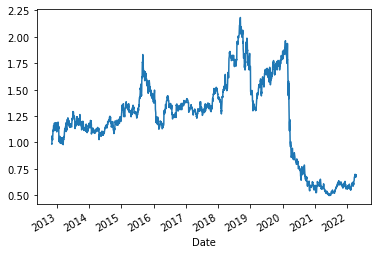

In [14]:
# Plot Strategy Returns to examine performance
(1 + signals_df['Strategy Returns']).cumprod().plot()

In [15]:
# Assign a copy of the sma_fast and sma_slow columns to a features DataFrame called X
X = signals_df[['SMA_Fast', 'SMA_Slow']].shift().dropna()

# Review the DataFrame
X.head()

,SMA_Fast,SMA_Slow
Date,,
2012-11-05,21.422798,21.898074
2012-11-06,21.231071,21.899219
2012-11-07,21.072202,21.892370
2012-11-08,20.798393,21.879528
2012-11-09,20.455714,21.866852


In [16]:
# Create the target set selecting the Signal column and assiging it to y
y = signals_df['Signal']

# Review the value counts
y.value_counts()

 1.0    1250
-1.0    1128
Name: Signal, dtype: int64

In [17]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

2012-11-05 00:00:00


In [19]:
# Select the ending period for the training data with an offset of 3 months
training_end = X.index.min() + DateOffset(months=7)

# Display the training end date
print(training_end)

2013-06-05 00:00:00


In [20]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Review the X_train DataFrame
X_train.head()

,SMA_Fast,SMA_Slow
Date,,
2012-11-05,21.422798,21.898074
2012-11-06,21.231071,21.899219
2012-11-07,21.072202,21.892370
2012-11-08,20.798393,21.879528
2012-11-09,20.455714,21.866852


In [21]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end+DateOffset(hours=1):]
y_test = y.loc[training_end+DateOffset(hours=1):]

# Review the X_test DataFrame
X_test.head()

,SMA_Fast,SMA_Slow
Date,,
2013-06-06,16.020238,16.923036
2013-06-07,15.981607,16.896393
2013-06-10,15.923453,16.872140
2013-06-11,15.858929,16.850015
2013-06-12,15.780833,16.827036


In [22]:
# Scale the features DataFrames

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [25]:
# From SVM, instantiate SVC classifier model instance
svm_model = svm.SVC()
 
# Fit the model to the data using the training data
svm_model = svm_model.fit(X_train_scaled, y_train)
 
# Use the testing data to make the model predictions
svm_pred = svm_model.predict(X_test_scaled)

# Review the model's predicted values
svm_pred

array([ 1.,  1.,  1., ..., -1., -1., -1.])

In [26]:
# Use a classification report to evaluate the model using the predictions and testing data
svm_testing_report = classification_report(y_test, svm_pred)

# Print the classification report
print(svm_testing_report)

              precision    recall  f1-score   support

        -1.0       0.47      0.98      0.63      1047
         1.0       0.50      0.02      0.03      1184

    accuracy                           0.47      2231
   macro avg       0.48      0.50      0.33      2231
weighted avg       0.49      0.47      0.32      2231



In [27]:
# Create a new empty predictions DataFrame.

# Create a predictions DataFrame
predictions_df = pd.DataFrame(index=X_test.index)

# Add the SVM model predictions to the DataFrame
predictions_df['Predicted'] = svm_pred

# Add the actual returns to the DataFrame
predictions_df['Actual Returns'] = signals_df['Actual Returns'] 

# Add the strategy returns to the DataFrame
predictions_df['Strategy Returns'] = predictions_df['Actual Returns'] * predictions_df['Predicted']

# Review the DataFrame
display(predictions_df.head())
display(predictions_df.tail())

,Predicted,Actual Returns,Strategy Returns
Date,,,
2013-06-06,1.0,-0.014940,-0.014940
2013-06-07,1.0,0.007640,0.007640
2013-06-10,1.0,-0.006609,-0.006609
2013-06-11,1.0,-0.002939,-0.002939
2013-06-12,1.0,-0.012363,-0.012363


,Predicted,Actual Returns,Strategy Returns
Date,,,
2022-04-07,-1.0,0.001804,-0.001804
2022-04-08,-1.0,-0.011909,0.011909
2022-04-11,-1.0,-0.025516,0.025516
2022-04-12,-1.0,0.011523,-0.011523
2022-04-13,-1.0,0.016343,-0.016343


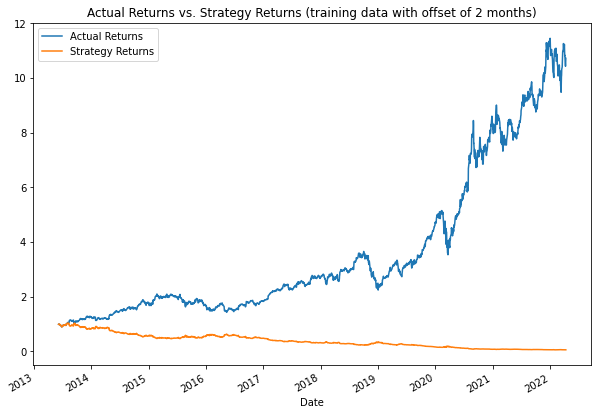

In [28]:
# Plot the actual returns versus the strategy returns
plot = (1 + predictions_df[['Actual Returns', 'Strategy Returns']]).cumprod().plot(
    figsize=(10,7), title="Actual Returns vs. Strategy Returns (training data with offset of 2 months)")


Evaluate a New Machine Learning Classifier - Logistic Regression

In [29]:
# Import a new classifier from SKLearn
from sklearn.linear_model import LogisticRegression 

# Initiate the model instance
logistic_regression_model = LogisticRegression()

In [30]:
# Fit the model using the training data
model = logistic_regression_model.fit(X_train_scaled, y_train)

# Use the testing dataset to generate the predictions for the new model
pred = model.predict(X_test_scaled)

# Review the model's predicted values
pred[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [31]:
# Use a classification report to evaluate the model using the predictions and testing data
lr_training_report = classification_report(y_test, pred)

# Print the classification report
print(lr_training_report)

              precision    recall  f1-score   support

        -1.0       0.47      0.96      0.63      1047
         1.0       0.56      0.05      0.08      1184

    accuracy                           0.47      2231
   macro avg       0.51      0.50      0.36      2231
weighted avg       0.52      0.47      0.34      2231



In [32]:
# Create a new empty predictions DataFrame.

# Create a predictions DataFrame
predictions_df_lr = pd.DataFrame(index=X_test.index)

# Add the SVM model predictions to the DataFrame
predictions_df_lr['Predicted'] = pred

# Add the actual returns to the DataFrame
predictions_df_lr['Actual Returns'] = signals_df['Actual Returns']

# Add the strategy returns to the DataFrame
predictions_df_lr['Strategy Returns'] = predictions_df_lr['Actual Returns'] * predictions_df_lr['Predicted']

# Review the DataFrame
display(predictions_df_lr.head())
display(predictions_df_lr.tail())

,Predicted,Actual Returns,Strategy Returns
Date,,,
2013-06-06,1.0,-0.014940,-0.014940
2013-06-07,1.0,0.007640,0.007640
2013-06-10,1.0,-0.006609,-0.006609
2013-06-11,1.0,-0.002939,-0.002939
2013-06-12,1.0,-0.012363,-0.012363


,Predicted,Actual Returns,Strategy Returns
Date,,,
2022-04-07,-1.0,0.001804,-0.001804
2022-04-08,-1.0,-0.011909,0.011909
2022-04-11,-1.0,-0.025516,0.025516
2022-04-12,-1.0,0.011523,-0.011523
2022-04-13,-1.0,0.016343,-0.016343


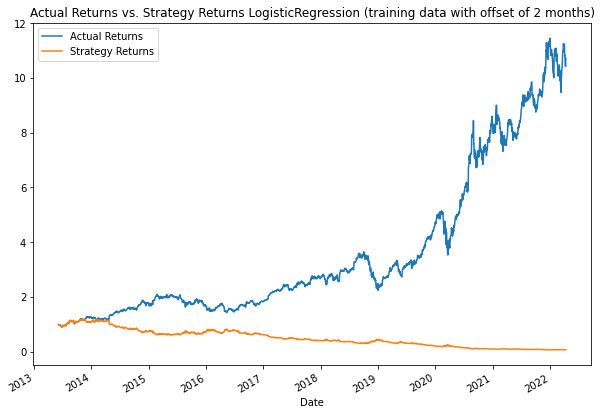

In [33]:
# Plot the actual returns versus the strategy returns
plot = (1 + predictions_df_lr[["Actual Returns", "Strategy Returns"]]).cumprod().plot(
    figsize=(10,7), title="Actual Returns vs. Strategy Returns LogisticRegression (training data with offset of 2 months)")

Evaluate a New Machine Learning Classifier - Random Forest Classifier

In [34]:
# Import a new classifier from SKLearn
from sklearn.ensemble import RandomForestClassifier

# Initiate the model instance
rfclf = RandomForestClassifier(n_estimators=100)

In [35]:
# Fit the model using the training data
model = rfclf.fit(X_train_scaled, y_train)

# Use the testing dataset to generate the predictions for the new model
pred = model.predict(X_test_scaled)

# Review the model's predicted values
pred[:10]

array([-1., -1., -1., -1., -1., -1.,  1., -1.,  1.,  1.])

In [36]:
# Use a classification report to evaluate the model using the predictions and testing data
rf_testing_report = classification_report(y_test, pred)

# Print the classification report
print(rf_testing_report)

              precision    recall  f1-score   support

        -1.0       0.48      0.13      0.20      1047
         1.0       0.53      0.88      0.66      1184

    accuracy                           0.52      2231
   macro avg       0.50      0.50      0.43      2231
weighted avg       0.51      0.52      0.45      2231



In [37]:
# Create a new empty predictions DataFrame.

# Create a predictions DataFrame
predictions_df_rf = pd.DataFrame(index=X_test.index)

# Add the SVM model predictions to the DataFrame
predictions_df_rf['Predicted'] = pred

# Add the actual returns to the DataFrame
predictions_df_rf['Actual Returns'] = signals_df['Actual Returns']

# Add the strategy returns to the DataFrame
predictions_df_rf['Strategy Returns'] = predictions_df_rf['Actual Returns'] * predictions_df_rf['Predicted']

# Review the DataFrame
display(predictions_df_rf.head())

,Predicted,Actual Returns,Strategy Returns
Date,,,
2013-06-06,-1.0,-0.014940,0.014940
2013-06-07,-1.0,0.007640,-0.007640
2013-06-10,-1.0,-0.006609,0.006609
2013-06-11,-1.0,-0.002939,0.002939
2013-06-12,-1.0,-0.012363,0.012363


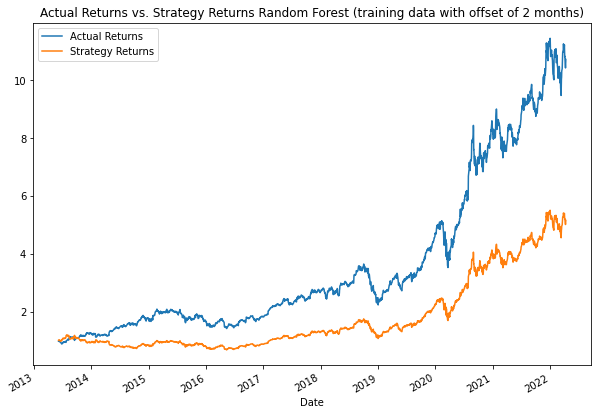

In [38]:
# Plot the actual returns versus the strategy returns
plot = (1 + predictions_df_rf[["Actual Returns", "Strategy Returns"]]).cumprod().plot(
    figsize=(10,7), title="Actual Returns vs. Strategy Returns Random Forest (training data with offset of 2 months)")

Evaluate a New Machine Learning Classifier - AdaBoost

In [39]:
# Import a new classifier from SKLearn
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Initiate the model instance
adaboost_model = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=200
)

In [40]:
# Fit the model using the training data
model = adaboost_model.fit(X_train_scaled, y_train)

# Use the testing dataset to generate the predictions for the new model
pred = model.predict(X_test_scaled)

# Review the model's predicted values
pred[:10]

array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.])

In [41]:
ab_testing_report = classification_report(y_test, pred)

# Print the classification report
print(ab_testing_report)

              precision    recall  f1-score   support

        -1.0       0.47      0.11      0.17      1047
         1.0       0.53      0.90      0.67      1184

    accuracy                           0.53      2231
   macro avg       0.50      0.50      0.42      2231
weighted avg       0.50      0.53      0.44      2231



In [42]:
# Create a new empty predictions DataFrame.

# Create a predictions DataFrame
predictions_df_ab = pd.DataFrame(index=X_test.index)

# Add the SVM model predictions to the DataFrame
predictions_df_ab['Predicted'] = pred

# Add the actual returns to the DataFrame
predictions_df_ab['Actual Returns'] = signals_df['Actual Returns']

# Add the strategy returns to the DataFrame
predictions_df_ab['Strategy Returns'] = predictions_df_ab['Actual Returns'] * predictions_df_ab['Predicted']

# Review the DataFrame
display(predictions_df_ab.head())
display(predictions_df_ab.tail())

,Predicted,Actual Returns,Strategy Returns
Date,,,
2013-06-06,-1.0,-0.014940,0.014940
2013-06-07,-1.0,0.007640,-0.007640
2013-06-10,-1.0,-0.006609,0.006609
2013-06-11,-1.0,-0.002939,0.002939
2013-06-12,-1.0,-0.012363,0.012363


,Predicted,Actual Returns,Strategy Returns
Date,,,
2022-04-07,1.0,0.001804,0.001804
2022-04-08,1.0,-0.011909,-0.011909
2022-04-11,1.0,-0.025516,-0.025516
2022-04-12,1.0,0.011523,0.011523
2022-04-13,1.0,0.016343,0.016343


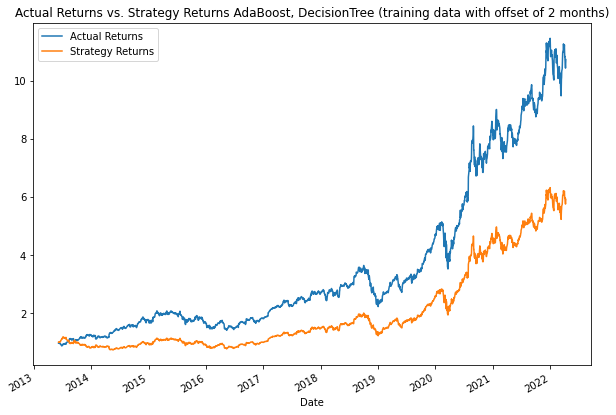

In [43]:
# Plot the actual returns versus the strategy returns
plot = (1 + predictions_df_ab[["Actual Returns", "Strategy Returns"]]).cumprod().plot(
    figsize=(10,7), title="Actual Returns vs. Strategy Returns AdaBoost, DecisionTree (training data with offset of 2 months)")

Evaluate a New Machine Learning Classifier - Naive Bayes 

In [44]:
# Import a new classifier from SKLearn
from sklearn.naive_bayes import GaussianNB

# Initiate the model instance
naive_bayes_model = GaussianNB()

In [45]:
# Fit the model using the training data
model = naive_bayes_model.fit(X_train_scaled, y_train)

# Use the testing dataset to generate the predictions for the new model
pred = model.predict(X_test_scaled)

# Review the model's predicted values
pred[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [46]:
# Use a classification report to evaluate the model using the predictions and testing data
nb_testing_report = classification_report(y_test, pred)

# Print the classification report
print(nb_testing_report)

              precision    recall  f1-score   support

        -1.0       0.45      0.23      0.30      1047
         1.0       0.52      0.75      0.62      1184

    accuracy                           0.51      2231
   macro avg       0.49      0.49      0.46      2231
weighted avg       0.49      0.51      0.47      2231



In [47]:
# Create a new empty predictions DataFrame.

# Create a predictions DataFrame
predictions_df_nb = pd.DataFrame(index=X_test.index)

# Add the SVM model predictions to the DataFrame
predictions_df_nb['Predicted'] = pred

# Add the actual returns to the DataFrame
predictions_df_nb['Actual Returns'] = signals_df['Actual Returns']

# Add the strategy returns to the DataFrame
predictions_df_nb['Strategy Returns'] = predictions_df_nb['Actual Returns'] * predictions_df_nb['Predicted']

# Review the DataFrame
display(predictions_df_nb.head())
display(predictions_df_nb.tail())

,Predicted,Actual Returns,Strategy Returns
Date,,,
2013-06-06,1.0,-0.014940,-0.014940
2013-06-07,1.0,0.007640,0.007640
2013-06-10,1.0,-0.006609,-0.006609
2013-06-11,1.0,-0.002939,-0.002939
2013-06-12,1.0,-0.012363,-0.012363


,Predicted,Actual Returns,Strategy Returns
Date,,,
2022-04-07,1.0,0.001804,0.001804
2022-04-08,1.0,-0.011909,-0.011909
2022-04-11,1.0,-0.025516,-0.025516
2022-04-12,1.0,0.011523,0.011523
2022-04-13,1.0,0.016343,0.016343


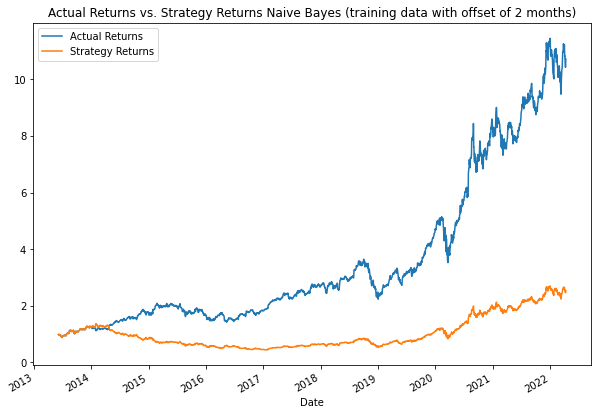

In [48]:
# Plot the actual returns versus the strategy returns
plot = (1 + predictions_df_nb[["Actual Returns", "Strategy Returns"]]).cumprod().plot(
    figsize=(10,7), title="Actual Returns vs. Strategy Returns Naive Bayes (training data with offset of 2 months)")